In [107]:
import pandas as pd
import numpy as np
import gseapy as gp
import seaborn as sns
import scanpy as sc
from goatools import obo_parser
from goatools.goea.go_enrichment_ns import GOEnrichmentStudy
from scipy.stats import hypergeom
from goatools import obo_parser
import matplotlib.pyplot as plt

In [108]:
sc.settings.verbosity = 3
sc.logging.print_versions()
sc.settings.set_figure_params(dpi = 300, color_map = 'RdPu', dpi_save = 300, vector_friendly = True, format = 'svg')

-----
anndata     0.10.8
scanpy      1.10.2
-----
PIL                 10.3.0
asttokens           NA
brotli              1.1.0
certifi             2024.07.04
cffi                1.16.0
charset_normalizer  3.3.2
comm                0.2.2
compat              NA
cycler              0.12.1
cython_runtime      NA
dateutil            2.9.0.post0
debugpy             1.8.2
decorator           5.1.1
django              5.0.6
et_xmlfile          1.1.0
executing           2.0.1
ftpretty            NA
goatools            1.4.12
gseapy              1.1.3
h5py                3.11.0
idna                3.7
ipykernel           6.29.5
jaraco              NA
jedi                0.19.1
joblib              1.4.2
kiwisolver          1.4.5
legacy_api_wrap     NA
llvmlite            0.43.0
matplotlib          3.9.1
matplotlib_inline   0.1.7
more_itertools      10.3.0
mpl_toolkits        NA
natsort             8.4.0
numba               0.60.0
numpy               2.0.0
openpyxl            3.1.4
packaging       

In [109]:
# Load the data
wt_vcm3 = pd.read_excel('./Copy of DMD-DE_results.xlsx', sheet_name='wt_vcm3')

# Prepare gene lists
up = wt_vcm3.loc[wt_vcm3['log_fold_change'] > 1.0, 'gene_id'].dropna().tolist()
down = wt_vcm3.loc[wt_vcm3['log_fold_change'] < -1.0, 'gene_id'].dropna().tolist()

In [110]:
#gp.get_library_name(organism= 'Mouse')

In [111]:
enrichr_up = gp.enrichr(
    gene_list=up,
    gene_sets= 'Reactome_2022',  
    organism='Mouse',
    outdir=None )

enrichr_up
df_up = enrichr_up.results
df_up['Regulation'] = 'Up-regulated'


In [112]:

# Perform enrichment analysis for down-regulated genes
enrichr_down = gp.enrichr(
    gene_list=down,
    gene_sets=  'Reactome_2022', 
    organism='Human',
    outdir=None
)
df_down = enrichr_down.results
df_down['Regulation'] = 'Down-regulated'


In [113]:
# Ensure 'Adjusted P-value' is numeric and sort values
df_up['Adjusted P-value'] = pd.to_numeric(df_up['Adjusted P-value'], errors='coerce')
df_down['Adjusted P-value'] = pd.to_numeric(df_down['Adjusted P-value'], errors='coerce')

# Filter pathways containing the term 'Signaling'
df_up_signaling = df_up[df_up['Term'].str.contains('Signaling', case=False, na=False)]
df_down_signaling = df_down[df_down['Term'].str.contains('Signaling', case=False, na=False)]

# Sort values and select top 5
top_up_signaling = df_up_signaling.sort_values(by='Adjusted P-value').head(5)
top_down_signaling = df_down_signaling.sort_values(by='Adjusted P-value').head(5)

# Combine the results
combined_df_signaling = pd.concat([top_up_signaling, top_down_signaling])

# Reset index for clarity
combined_df_signaling.reset_index(drop=True, inplace=True)

# Adjust p-values for visualization
combined_df_signaling['Adjusted P-value'] = combined_df_signaling.apply(
    lambda row: -row['Adjusted P-value'] if row['Regulation'] == 'Down-regulated' 
    else row['Adjusted P-value'], axis=1
)

# Sort values for better visualization
combined_df_signaling.sort_values(by='Adjusted P-value', inplace=True)


In [114]:
df_up_signaling

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes,Regulation
22,Reactome_2022,Signaling By ROBO Receptors R-HSA-376176,32/209,2.376375e-38,5.961602e-37,0,0,48.171018,4173.183334,RPL32;RPL34;RPLP0;RPL36A;RPL6;RPL7;RPS15;RPS4X...,Up-regulated
60,Reactome_2022,Inactivation Of CSF3 (G-CSF) Signaling R-HSA-9...,3/25,3.057187e-04,2.845156e-03,0,0,26.308914,212.913973,UBB;ELOB;RPS27A,Up-regulated
64,Reactome_2022,Signaling By CSF3 (G-CSF) R-HSA-9674555,3/30,5.293731e-04,4.699204e-03,0,0,21.431499,161.675311,UBB;ELOB;RPS27A,Up-regulated
65,Reactome_2022,FLT3 Signaling By CBL Mutants R-HSA-9706377,2/7,5.742868e-04,4.945724e-03,0,0,76.496154,570.843489,UBB;RPS27A,Up-regulated
75,Reactome_2022,Downregulation Of ERBB4 Signaling R-HSA-1253288,2/9,9.776954e-04,7.422767e-03,0,0,54.634615,378.634950,UBB;RPS27A,Up-regulated
...,...,...,...,...,...,...,...,...,...,...,...
564,Reactome_2022,G Alpha (Q) Signaling Events R-HSA-416476,1/212,6.778011e-01,6.913307e-01,0,0,0.888422,0.345509,GNG5,Up-regulated
566,Reactome_2022,"Signaling By Rho GTPases, Miro GTPases And RHO...",3/660,6.841625e-01,6.962289e-01,0,0,0.852817,0.323695,HSP90AB1;ACTC1;NDUFA5,Up-regulated
571,Reactome_2022,G Alpha (I) Signaling Events R-HSA-418594,1/312,8.119510e-01,8.190485e-01,0,0,0.599694,0.124925,GNG5,Up-regulated
575,Reactome_2022,GPCR Downstream Signaling R-HSA-388396,1/619,9.646129e-01,9.662876e-01,0,0,0.297057,0.010702,GNG5,Up-regulated


In [115]:
df_down_signaling

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes,Regulation
8,Reactome_2022,Constitutive Signaling By Aberrant PI3K In Can...,2/78,0.006086,0.106217,0,0,18.697368,95.390945,ERBB4;FGF1,Down-regulated
15,Reactome_2022,PI3K/AKT Signaling In Cancer R-HSA-2219528,2/105,0.010791,0.106217,0,0,13.777393,62.398235,ERBB4;FGF1,Down-regulated
16,Reactome_2022,"PI5P, PP2A And IER3 Regulate PI3K/AKT Signalin...",2/106,0.010988,0.106217,0,0,13.644231,61.547877,ERBB4;FGF1,Down-regulated
18,Reactome_2022,Role Of ABL In ROBO-SLIT Signaling R-HSA-428890,1/8,0.011939,0.106217,0,0,98.339901,435.442406,CLASP1,Down-regulated
20,Reactome_2022,Downregulation Of ERBB4 Signaling R-HSA-1253288,1/9,0.013422,0.106217,0,0,86.043103,370.920877,ERBB4,Down-regulated
...,...,...,...,...,...,...,...,...,...,...,...
210,Reactome_2022,"Platelet Activation, Signaling And Aggregation...",1/254,0.318677,0.344353,0,0,2.687338,3.073176,PCDH7,Down-regulated
211,Reactome_2022,Signaling By Nuclear Receptors R-HSA-9006931,1/260,0.324865,0.349384,0,0,2.624284,2.950600,ERBB4,Down-regulated
215,Reactome_2022,Signaling By WNT R-HSA-195721,1/294,0.358918,0.378858,0,0,2.315759,2.372870,SOX6,Down-regulated
217,Reactome_2022,G Alpha (I) Signaling Events R-HSA-418594,1/312,0.376267,0.393527,0,0,2.179732,2.130592,PDE4B,Down-regulated


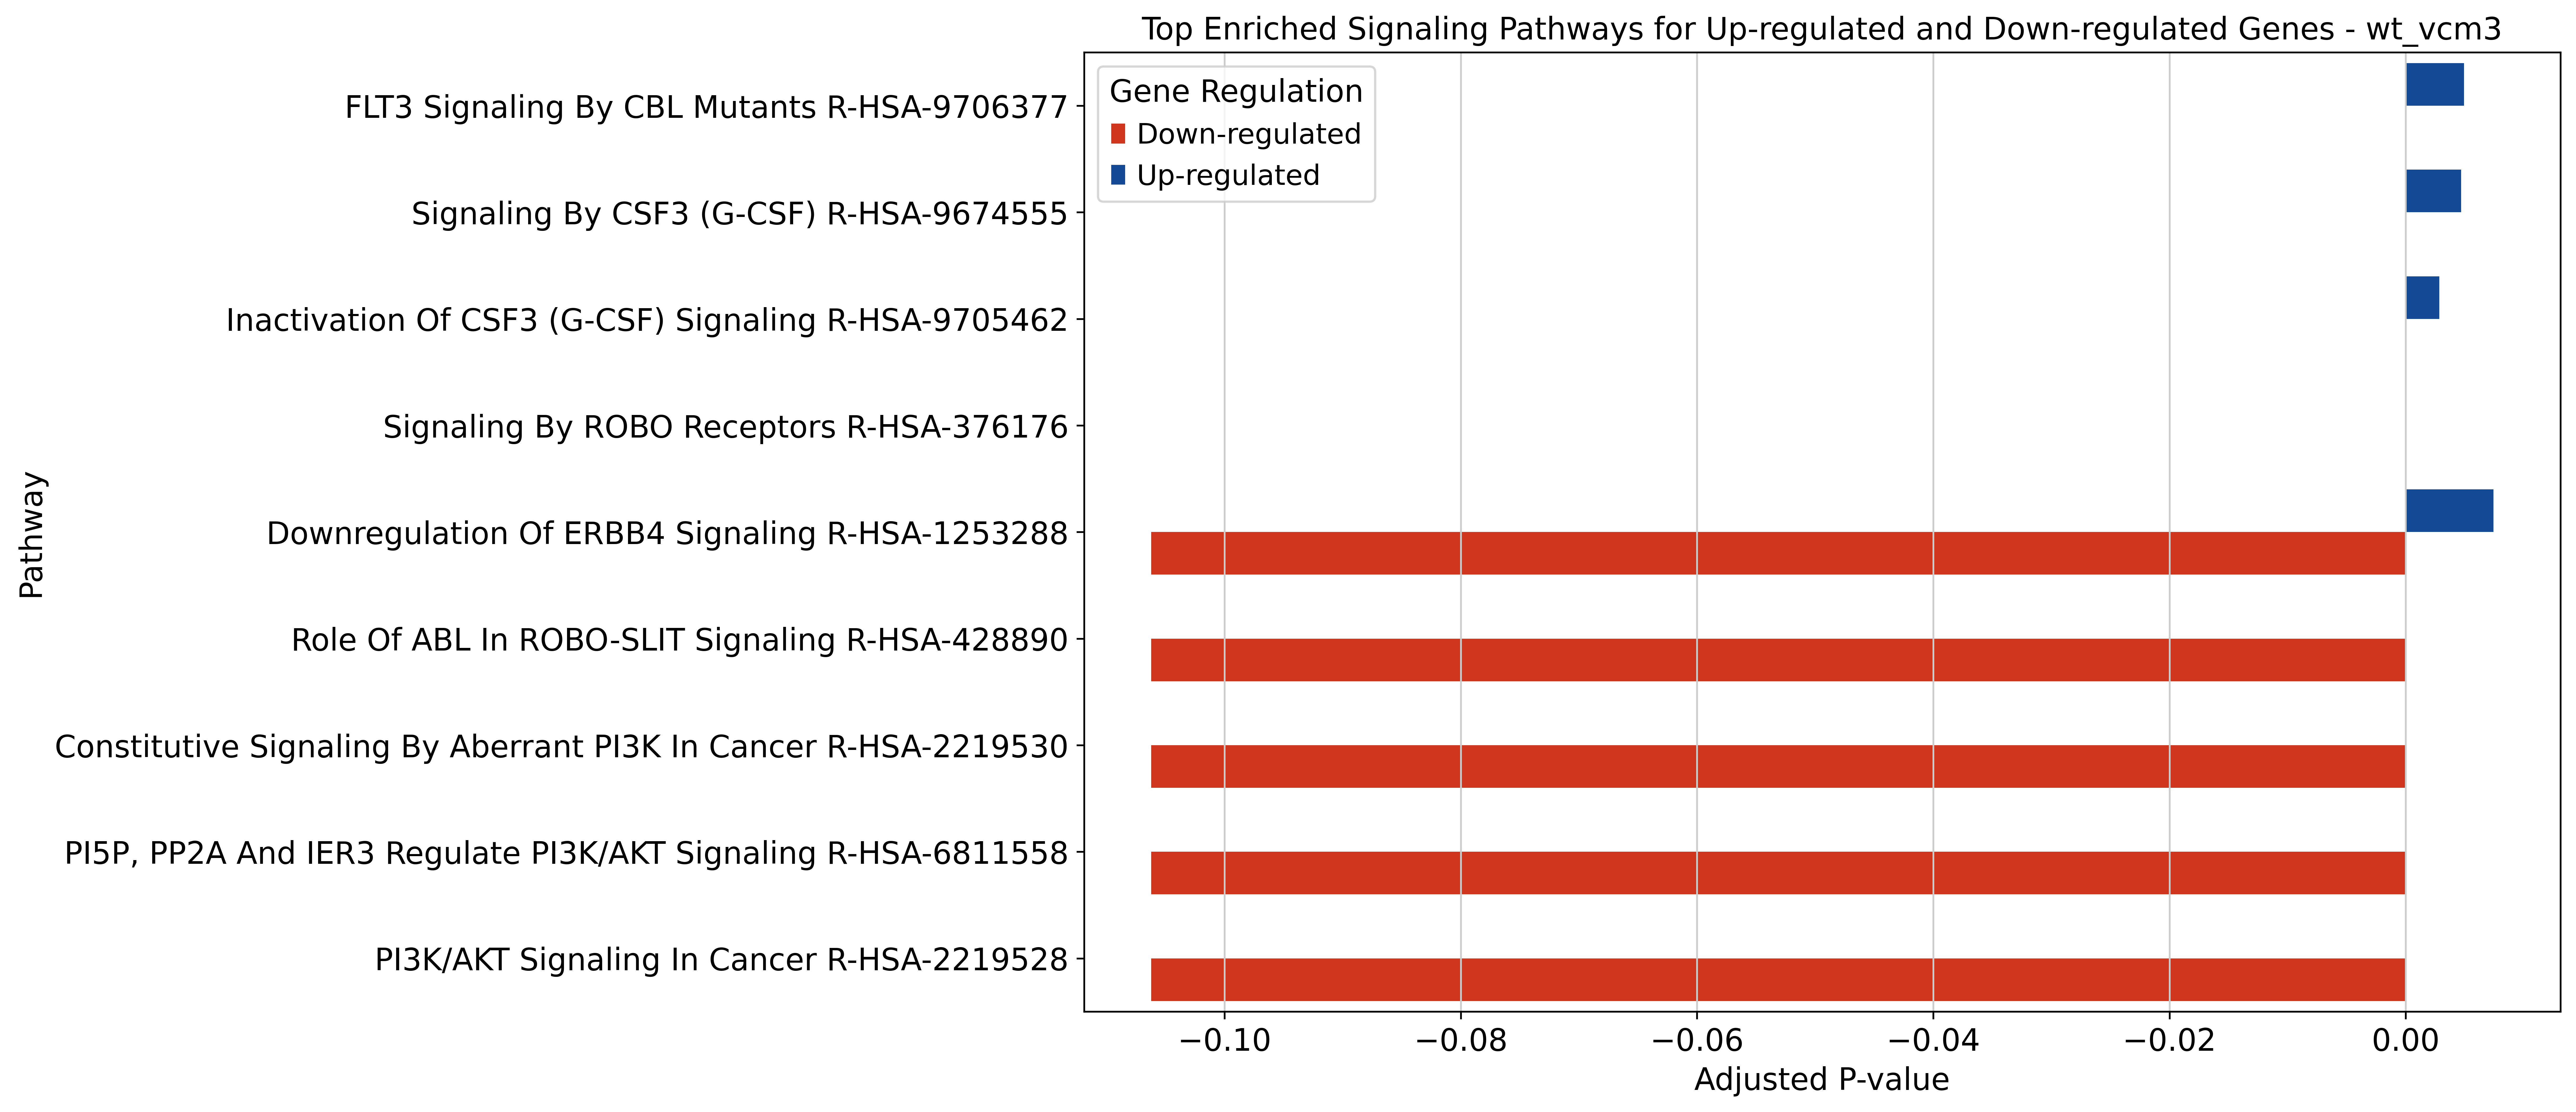

<Figure size 1200x1200 with 0 Axes>

In [117]:
# Plotting
plt.figure(figsize=(12, 8))

# Define colors using hex codes
colors = {'Up-regulated': '#0047AB',  # Cobalt Blue
          'Down-regulated': '#ED2100'}  # Scarlet

# Create a barplot
barplot = sns.barplot(x='Adjusted P-value', y='Term', hue='Regulation', data=combined_df_signaling, palette=colors)

# Customize plot
plt.xlabel('Adjusted P-value')
plt.ylabel('Pathway')
plt.title('Top Enriched Signaling Pathways for Up-regulated and Down-regulated Genes - wt_vcm3')

# Invert y-axis to have the lowest p-value on top
plt.gca().invert_yaxis()

# Adjust legend
plt.legend(title='Gene Regulation')

plt.show()

# Save plot
plt.savefig('./figures/path-reactome-wt_vcm3.png')